# Simple Classification

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import cm
import seaborn as sns 

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from macest.classification import models as clmod
from macest.classification import plots as clplot

from plotting_utils import plot_prediction_conf_surface, plot_macest_sklearn_comparison_surface

In [3]:
sns.set_context("notebook")
sns.set_style('darkgrid')

### Plotting Functions

### Generate some data and split it into 4 groups

In [4]:
X,y = datasets.make_circles(n_samples= 10**4, noise = 0.4, factor =10**-1)

X_pp_train, X_conf_train, y_pp_train, y_conf_train  = train_test_split(X, y, test_size=0.66, random_state=10)
X_conf_train, X_cal, y_conf_train, y_cal = train_test_split(X_conf_train, y_conf_train,
                                                            test_size=0.5, random_state=0)
X_cal, X_test, y_cal,  y_test, = train_test_split(X_cal, y_cal, test_size=0.5, random_state=0)

Text(0, 0.5, 'x2')

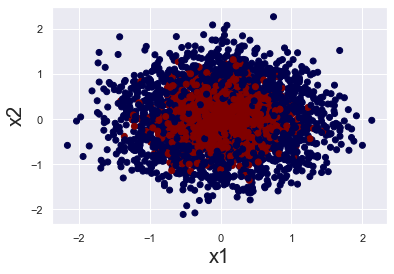

In [5]:
plt.scatter(X_conf_train[:,0],X_conf_train[:,1], c=y_conf_train, cmap = cm.seismic)
plt.xlabel('x1', fontsize = 20)
plt.ylabel('x2', fontsize = 20)

### Train a point prediction model

In [6]:
model = RandomForestClassifier(random_state =0,
                               n_estimators =800,
                               n_jobs =-1)

model.fit(X_pp_train, y_pp_train)

RandomForestClassifier(n_estimators=800, n_jobs=-1, random_state=0)

In [7]:
param_bounds = clmod.SearchBounds(alpha_bounds = (0, 500), k_bounds = (5,15))
neighbour_search_params = clmod.HnswGraphArgs(query_args = dict(ef = 1100))

In [8]:
macest_model = clmod.ModelWithConfidence(model,
                                       X_conf_train,
                                       y_conf_train)

macest_model.fit(X_cal, y_cal)

### Let's have a look at the performance of the model on unseen data, we will compare to the random forest confidence predictions

In [9]:
preds = model.predict(X_test)
conf_preds = macest_model.predict_proba(X_test)
rf_conf_preds = model.predict_proba(X_test)

In [10]:
macest_point_prediction_conf = macest_model.predict_confidence_of_point_prediction(X_test) 
                              
rf_point_prediction_conf = np.amax(rf_conf_preds, axis=1)

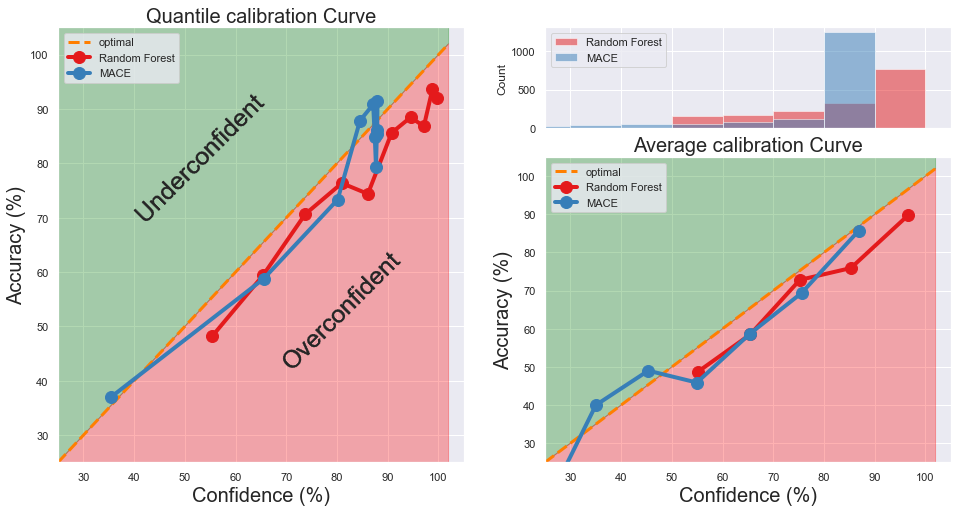

In [11]:
clplot.plot_calibration_curve([rf_point_prediction_conf,
                               macest_point_prediction_conf], 
                              ['Random Forest', 'MACE'],
                              preds,
                              y_test)

### Let's compare calibration and forecast metrics

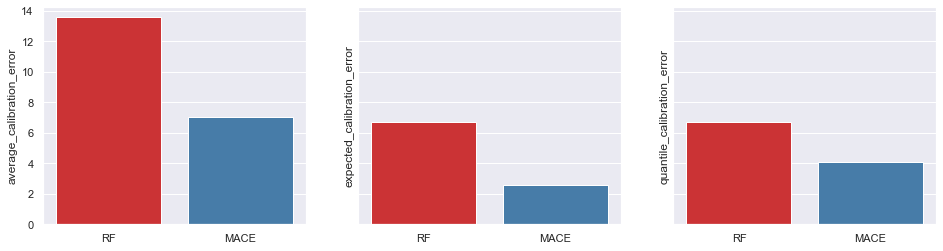

In [12]:
clplot.plot_calibration_metrics([rf_point_prediction_conf, 
                                macest_point_prediction_conf], 
                              [ 'RF','MACE'], preds, y_test)

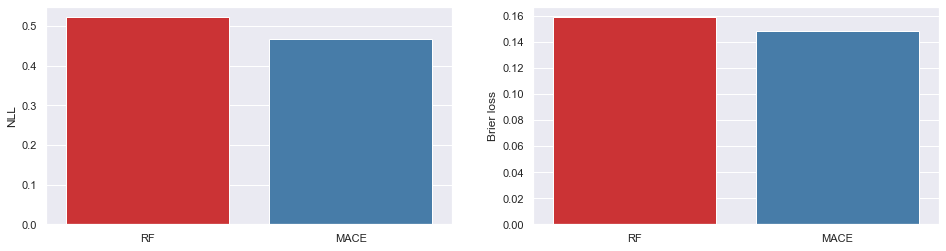

In [13]:
clplot.plot_forecast_metrics([rf_point_prediction_conf, 
                                macest_point_prediction_conf], 
                              [ 'RF','MACE'], preds, y_test)

## What does the surface learnt by the random forest  look like ?

#### As expected it is able to partition the space around the circles, it then extrapolates this surface and predicts anything outside of the inner circle as blue no matter how far we are from the data, this is probably what we want to happen.

#### If we now look at the confidence plot we see that apart from the boundary, between the two circles the random forest is >90% confident. This high confident  is also extrapolated very far from the data, this is probably bad as we have no relevant data 20 standard deviations away from the data

/Users/mattrowe/code/macest/notebooks/classification/plotting_utils.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[1, 0].scatter(X_pp_train[:, 0], X_pp_train[:, 1],
/Users/mattrowe/code/macest/notebooks/classification/plotting_utils.py:66: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[1, 1].scatter(X_pp_train[:, 0], X_pp_train[:, 1],


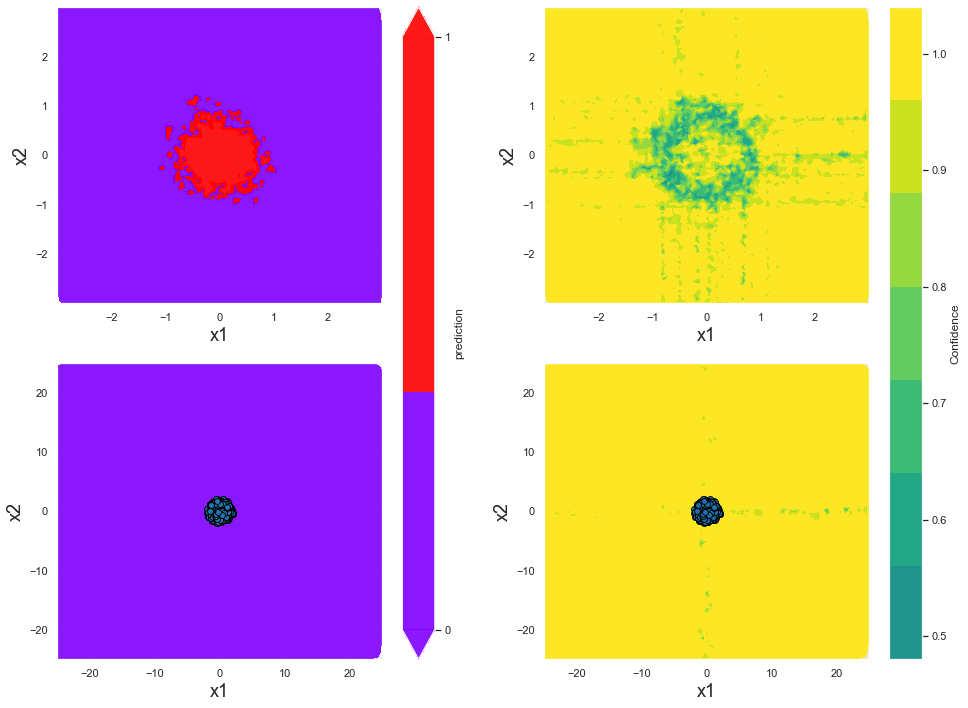

In [14]:
plot_prediction_conf_surface(3, 25, model, X_pp_train=X_pp_train, plot_training_data=False)

## Let's now compare those confidence estimates with MACEst

#### MACEst also learns to be very confident close to the data, however as we move further away from the data we see that the confidence drops off. At a certain point MACEst will return close an approximately uniform distribution, this suggests that we do not have the relevant data to be confident about the prediction

/Users/mattrowe/code/macest/notebooks/classification/plotting_utils.py:183: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0, 0].scatter(X_pp_train[:, 0], X_pp_train[:, 1],
/Users/mattrowe/code/macest/notebooks/classification/plotting_utils.py:188: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0, 1].scatter(X_pp_train[:, 0], X_pp_train[:, 1],
/Users/mattrowe/code/macest/notebooks/classification/plotting_utils.py:199: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[1, 0].scatter(X_pp_train[:, 0], X_pp_train[:, 1],
/Users/mattrowe/code/macest/notebooks/classification/plotting_utils.py:210: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[1, 1].scatter(X_pp_train[:, 0], X_pp_train[:, 1],


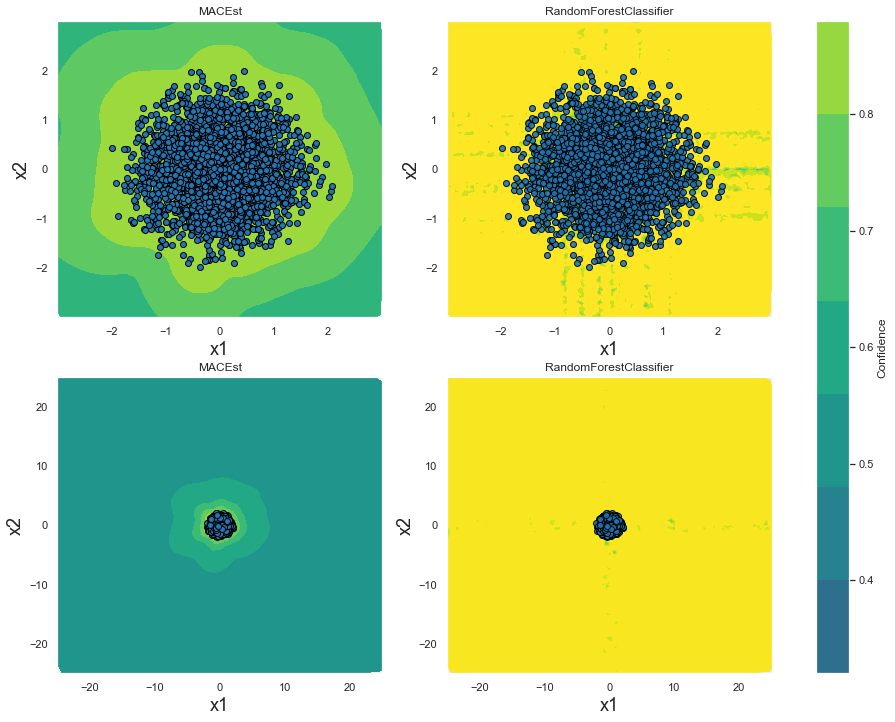

In [15]:
plot_macest_sklearn_comparison_surface(3, 25, macest_model, model, X_pp_train=X_pp_train, plot_training_data=True)

/Users/mattrowe/code/macest/notebooks/classification/plotting_utils.py:183: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0, 0].scatter(X_pp_train[:, 0], X_pp_train[:, 1],
/Users/mattrowe/code/macest/notebooks/classification/plotting_utils.py:188: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0, 1].scatter(X_pp_train[:, 0], X_pp_train[:, 1],
/Users/mattrowe/code/macest/notebooks/classification/plotting_utils.py:199: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[1, 0].scatter(X_pp_train[:, 0], X_pp_train[:, 1],
/Users/mattrowe/code/macest/notebooks/classification/plotting_utils.py:210: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[1, 1].scatter(X_pp_train[:, 0], X_pp_train[:, 1],


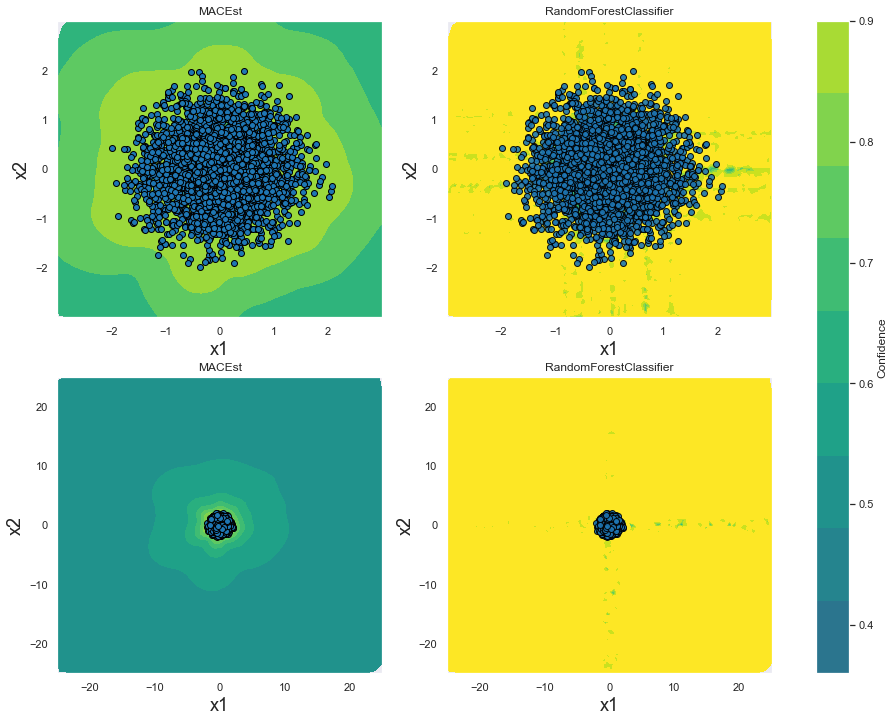

In [16]:
plot_macest_sklearn_comparison_surface(3, 25, macest_model, model, X_pp_train=X_pp_train, plot_training_data=True)